In [ ]:
import numpy as np
import pandas as pd
import random
import torch
from matplotlib import pyplot as plt
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import plotly
import plotly.graph_objs as go

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [ ]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

In [ ]:
import collections

In [ ]:
!pip install apimoex

In [ ]:
import requests
import apimoex

session = requests.Session()

In [ ]:
df = pd.DataFrame(apimoex.get_board_history(session, 'MOEX')).dropna()
df = df[-5000:]
df = df.reset_index(drop=True)
print(df.head())

  BOARDID   TRADEDATE  CLOSE  VOLUME       VALUE
0    TQBR  2013-04-04  48.13  210880  10148463.2
1    TQBR  2013-04-05  47.69  345780  16698661.4
2    TQBR  2013-04-08  47.54  227840  10889442.1
3    TQBR  2013-04-09  47.48  425000  20233800.0
4    TQBR  2013-04-10  46.96  140100   6624780.0


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    y = df['CLOSE'][:],
    line =  dict(shape =  'spline' ),
    name = 'Курс акции MOEX'
            ))
fig.show()

In [ ]:
class Environment:
    '''
        Рабочая среда робота, внутри которого будет
        происходить дальнейшее обучение
    '''
    def __init__(self, train_data, test_data, normalize = True, noise = True):
        self.train_length = train_data.shape[0]
        self.test_length = test_data.shape[0]
        self.data = np.concatenate([train_data.flatten(), test_data.flatten()])


        if noise:
            # add a noise
            self.data += np.random.normal(0, 0.05, size = self.data.shape)*self.data
        if normalize:
            # minmax normalization
            self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())

    def get_state(self, time, lookback, diff = True):
        """
        We return the derivatives of a separate window in our selection
        and remove the zeros at the beginning
        """
        window = self.data[time-lookback:time]
        if diff: window = np.diff(window, prepend = window.flatten()[0])
        return window

    def get_reward(self, action, action_time, reward_time, coef = 1, fee=0.001):
        """
        0 => long   1 => short
        """
        if action == -1:
            action = -3
        elif action == 1:
            action = 1

        # We pull out the current price
        price_now = self.data[action_time]
        # We pull out the next price
        price_reward = self.data[reward_time]
        # We get the difference
        price_diff = (price_reward - price_now)
        # We add the following number to the portfolio:
        # Delta of currency change * buy/sell/hold * purchase ratio  fee -- broker fee
        reward = price_diff * action * coef*(1-fee)

        return reward

We don't want to study trading, we need to develop intuition to predict the price. Thus, a small simple NN is needed.

In [ ]:
# define the nn architecture
class BioLinear(nn.Module):
    # BioLinear is just Linear, but each neuron comes with coordinates.
    def __init__(self, in_dim, out_dim, in_fold=1, out_fold=1):
        super(BioLinear, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear = nn.Linear(in_dim, out_dim)
        self.in_fold = in_fold # in_fold is the number of folds applied to input vectors. It only affects coordinates, not computations.
        self.out_fold = out_fold # out_fold is the number of folds applied to output vectors. It only affects coordinates, not computations.
        assert in_dim % in_fold == 0
        assert out_dim % out_fold == 0
        #compute in_cor, shape: (in_dim)
        in_dim_fold = int(in_dim/in_fold)
        out_dim_fold = int(out_dim/out_fold)
        self.in_coordinates = torch.tensor(list(np.linspace(1/(2*in_dim_fold), 1-1/(2*in_dim_fold), num=in_dim_fold))*in_fold, dtype=torch.float) # place input neurons in 1D Euclidean space
        self.out_coordinates = torch.tensor(list(np.linspace(1/(2*out_dim_fold), 1-1/(2*out_dim_fold), num=out_dim_fold))*out_fold, dtype=torch.float) # place output neurons in 1D Euclidean space
        self.input = None
        self.output = None

    def forward(self, x):
        self.input = x.clone()
        self.output = self.linear(x).clone()
        return self.output


class BioMLP(nn.Module):
    # BioMLP is just MLP, but each neuron comes with coordinates.
    def __init__(self, in_dim=2, out_dim=2, w=2, depth=2, shp=None, token_embedding=False, embedding_size=None):
        super(BioMLP, self).__init__()
        if shp == None:
            shp = [in_dim] + [w]*(depth-1) + [out_dim]
            self.in_dim = in_dim
            self.out_dim = out_dim
            self.depth = depth

        else:
            self.in_dim = shp[0]
            self.out_dim = shp[-1]
            self.depth = len(shp) - 1

        linear_list = []
        for i in range(self.depth):
            if i == 0:
                linear_list.append(BioLinear(shp[i], shp[i+1], in_fold=1))

            else:
                linear_list.append(BioLinear(shp[i], shp[i+1]))
        self.linears = nn.ModuleList(linear_list)


        if token_embedding == True:
            # embedding size: number of tokens * embedding dimension
            self.embedding = torch.nn.Parameter(torch.normal(0,1,size=embedding_size))

        self.shp = shp
        # parameters for the bio-inspired trick
        self.l0 = 0.1 # distance between two nearby layers
        self.in_perm = torch.nn.Parameter(torch.tensor(np.arange(int(self.in_dim/self.linears[0].in_fold)), dtype=torch.float))
        self.out_perm = torch.nn.Parameter(torch.tensor(np.arange(int(self.out_dim/self.linears[-1].out_fold)), dtype=torch.float))
        self.top_k = 5 # the number of important neurons (used in Swaps)
        self.token_embedding = token_embedding
        self.n_parameters = sum(p.numel() for p in self.parameters())
        self.original_params = None

    def forward(self, x):
        f = torch.nn.SiLU()
        for i in range(self.depth-1):
            x = f(self.linears[i](x))
        x = self.linears[-1](x)


        #x = x[:,self.out_perm]

        return x

    def get_linear_layers(self):
        return self.linears

    def get_cc(self, weight_factor=1.0, bias_penalize=True, no_penalize_last=False):
        # compute connection cost
        # bias_penalize = True penalizes biases, otherwise doesn't penalize biases
        # no_penalize_last = True means do not penalize last linear layer, False means penalize last layer.
        cc = 0
        num_linear = len(self.linears)
        for i in range(num_linear):
            if i == num_linear - 1 and no_penalize_last:
                weight_factor = 0.
            biolinear = self.linears[i]
            dist = torch.abs(biolinear.out_coordinates.unsqueeze(dim=1) - biolinear.in_coordinates.unsqueeze(dim=0))
            cc += torch.sum(torch.abs(biolinear.linear.weight)*(weight_factor*dist+self.l0))
            if bias_penalize == True:
                cc += torch.sum(torch.abs(biolinear.linear.bias)*(self.l0))
        if self.token_embedding:
            cc += torch.sum(torch.abs(self.embedding)*(self.l0))
            #pass
        return cc

    def swap_weight(self, weights, j, k, swap_type="out"):
        # Given a weight matrix, swap the j^th and k^th neuron in inputs/outputs when swap_type = "in"/"out"
        with torch.no_grad():
            if swap_type == "in":
                temp = weights[:,j].clone()
                weights[:,j] = weights[:,k].clone()
                weights[:,k] = temp
            elif swap_type == "out":
                temp = weights[j].clone()
                weights[j] = weights[k].clone()
                weights[k] = temp
            else:
                raise Exception("Swap type {} is not recognized!".format(swap_type))

    def swap_bias(self, biases, j, k):
        # Given a bias vector, swap the j^th and k^th neuron.
        with torch.no_grad():
            temp = biases[j].clone()
            biases[j] = biases[k].clone()
            biases[k] = temp

    def swap(self, i, j, k):
        # in the ith layer (of neurons), swap the jth and the kth neuron.
        # Note: n layers of weights means n+1 layers of neurons.
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer, only has outgoing weights; update in_perm
            weights = linears[i].linear.weight
            infold = linears[i].in_fold
            fold_dim = int(weights.shape[1]/infold)
            for l in range(infold):
                self.swap_weight(weights, j+fold_dim*l, k+fold_dim*l, swap_type="in")
            # change input_perm
            self.swap_bias(self.in_perm, j, k)
        elif i == num_linear:
            # output layer, only has incoming weights and biases; update out_perm
            weights = linears[i-1].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights, j, k, swap_type="out")
            self.swap_bias(biases, j, k)
            # change output_perm
            self.swap_bias(self.out_perm, j, k)
        else:
            # middle layer : incoming weights, outgoing weights, and biases
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights_in, j, k, swap_type="out")
            self.swap_weight(weights_out, j, k, swap_type="in")
            self.swap_bias(biases, j, k)

    def get_top_id(self, i, top_k=20):
        # in the ith layer (of neurons), get the top k important neurons (have large weight connections with other neurons)
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer
            weights = linears[i].linear.weight
            score = torch.sum(torch.abs(weights), dim=0)
            in_fold = linears[0].in_fold
            #print(score.shape)
            score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
        elif i == num_linear:
            # output layer
            weights = linears[i-1].linear.weight
            score = torch.sum(torch.abs(weights), dim=1)
        else:
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
        #print(score.shape)
        top_index = torch.flip(torch.argsort(score),[0])[:top_k]
        return top_index

    def relocate_ij(self, i, j):
        # In the ith layer (of neurons), relocate the jth neuron
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i < num_linear:
            num_neuron = int(linears[i].linear.weight.shape[1]/linears[i].in_fold)
        else:
            num_neuron = linears[i-1].linear.weight.shape[0]
        ccs = []
        for k in range(num_neuron):
            self.swap(i,j,k)
            ccs.append(self.get_cc())
            self.swap(i,j,k)
        k = torch.argmin(torch.stack(ccs))
        self.swap(i,j,k)

    def relocate_i(self, i):
        # Relocate neurons in the ith layer
        top_id = self.get_top_id(i, top_k=self.top_k)
        for j in top_id:
            self.relocate_ij(i,j)

    def relocate(self):
        # Relocate neurons in the whole model
        linears = self.get_linear_layers()
        num_linear = len(linears)
        for i in range(num_linear+1):
            self.relocate_i(i)

    def plot(self):
        fig, ax = plt.subplots(figsize=(3,3))
        #ax = plt.gca()
        shp = self.shp
        s = 1/(2*max(shp))
        for j in range(len(shp)):
            N = shp[j]
            if j == 0:
                in_fold = self.linears[j].in_fold
                N = int(N/in_fold)
            for i in range(N):
                if j == 0:
                    for fold in range(in_fold):
                        circle = Ellipse((1/(2*N)+i/N, 0.1*j+0.02*fold-0.01), s, s/10*((len(shp)-1)+0.4), color='black')
                        ax.add_patch(circle)
                else:
                    for fold in range(in_fold):
                        circle = Ellipse((1/(2*N)+i/N, 0.1*j), s, s/10*((len(shp)-1)+0.4), color='black')
                        ax.add_patch(circle)


        plt.ylim(-0.02,0.1*(len(shp)-1)+0.02)
        plt.xlim(-0.02,1.02)

        linears = self.linears
        for ii in range(len(linears)):
            biolinear = linears[ii]
            p = biolinear.linear.weight
            p_shp = p.shape
            p = p/torch.abs(p).max()
            in_fold = biolinear.in_fold
            fold_num = int(p_shp[1]/in_fold)
            for i in range(p_shp[0]):
                if ii == 0:
                    for fold in range(in_fold):
                        for j in range(fold_num):
                            plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*fold_num)+j/fold_num], [0.1*(ii+1),0.1*ii+0.02*fold-0.01], lw=1*np.abs(p[i,j].detach().numpy()), color="blue" if p[i,j]>0 else "red")
                else:
                    for j in range(fold_num):
                        plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*fold_num)+j/fold_num], [0.1*(ii+1),0.1*ii], lw=0.5*np.abs(p[i,j].detach().numpy()), color="blue" if p[i,j]>0 else "red")

        ax.axis('off')


    def thresholding(self, threshold, checkpoint = True):
        # snap too small weights (smaller than threshold) to zero. Useful for pruning.
        num = 0
        if checkpoint:
            self.original_params = [param.clone() for param in self.parameters()]
        with torch.no_grad():
            for param in self.parameters():
                num += torch.sum(torch.abs(param)>threshold)
                param.data = param*(torch.abs(param)>threshold)
        return num

    def intervening(self, i, pos, value, ptype="weight", checkpoint = True):
        if checkpoint:
            self.original_params = [param.clone() for param in self.parameters()]
        with torch.no_grad():
            if ptype == "weight":
                self.linears[i].linear.weight[pos] = value
            elif ptype == "bias":
                self.linears[i].linear.bias[pos] = value

    def revert(self):
        with torch.no_grad():
            for param, original_param in zip(self.parameters(), self.original_params):
                param.data.copy_(original_param.data)

In [ ]:
class BuyHoldSellAgent:
    '''
        Агент для покупки продажи
    '''
    def __init__(self, state_shape = 10, action_shape = 2, experience_size = 100):
        self.state_shape = state_shape
        self.action_shape = action_shape
        self.experience_size = experience_size
        self.experience = collections.deque(maxlen=self.experience_size)

        # Creating an instance of the model
        self.model = BioMLP(shp=[state_shape,64,32,action_shape])

        # Let's create an error function
        self.criterion = nn.SmoothL1Loss()
        # Let's add an optimizer
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=2e-4, weight_decay=0.00)

    def save_experience(self, current_state, action, reward, next_state):
        """A method for saving previous experimental data"""
        self.experience.append({
            'state_i': current_state,
            'action_i': action,
            'reward_i': reward,
            'state_i_1': next_state
        })

    def replay_experience(self, gamma, sample_size, epoch):
        """A method for optimizing training data"""
        # Creating a fixed selection from the added events
        indices_sampled = np.random.choice(
            len(self.experience),
            sample_size,
            replace=False
        )
        # We are going through only those elements that were added to the selection

        current_states = []
        actions = []
        rewards = []
        next_states = []
        for i in indices_sampled:
            state_i, action_i, reward_i, state_i_1 = self.experience[i]['state_i'], self.experience[i]['action_i'], self.experience[i]['reward_i'], self.experience[i]['state_i_1']
            current_states.append(state_i)
            actions.append(action_i)
            rewards.append(reward_i)
            next_states.append(state_i_1)

        current_states = np.array(current_states).squeeze()
        next_states = np.array(next_states).squeeze()

        # We get a forecast for the following state
        next_q_values = self.model(torch.from_numpy(next_states).float()).detach().numpy()

        # we get a forecast for the current state
        current_q_values = self.model(torch.from_numpy(current_states).float()).detach().numpy()
        # The Bellman equation
        for i in range(len(indices_sampled)):
            # we enter it in the Q table for training
            current_q_values[i, actions[i]] = rewards[i] + gamma * next_q_values[i, :].max()

        outputs = self.model(torch.from_numpy(np.expand_dims(current_states.reshape(-1, WINDOW_SHAPE), 0)).float())[0]
        reg = self.model.get_cc(weight_factor=1.)
        if epoch < 100:
          lambd = 0.000
        else: lambd = 0.003
        loss = self.criterion(outputs, torch.Tensor(current_q_values)) + lambd*reg
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return reg

    def get_value_action_value(self, state):
        """Метод для прогноза сигнала"""
        state = np.expand_dims(state, axis = 0)
        pred = self.model(torch.from_numpy(state).float())
        return pred.flatten()

In [ ]:
# number of epochs
epochs = 400
# The significance of the reward is one step ahead
gamma = 0.99
# initial epsilon
epsilon = 1.0
# epsilon_decay
alpha_e = 0.97

In [ ]:
# dataset size
DATASET_LENGTH = len(df['CLOSE'])
# The size of the window from which the previous data will be taken
WINDOW_SHAPE = 30
# Previous data step
REWARD_TIME = 1
# number of action
ACTIONS_SHAPE = 2
# Sample size
SAMPLE_SIZE = 50
EXP_SIZE = 64
# test size
SIZE_test = 200

In [ ]:
action_to_backtest_action = {
    1: 1,  # buy
    0: -1,  # sell
}

In [ ]:
train_dataset = np.array(df['CLOSE'][:-SIZE_test])
test_dataset = np.array(df['CLOSE'][-SIZE_test:])

In [ ]:
# We prescribe a new environment and transmit data on the closing price
set_random_seed(42)
environment = Environment(train_dataset, test_dataset, normalize = False, noise = False)
agent = BuyHoldSellAgent(WINDOW_SHAPE, ACTIONS_SHAPE, EXP_SIZE)

In [ ]:
def plot_ag():
  actions = []


  for j in range(WINDOW_SHAPE, len(df['CLOSE']), REWARD_TIME):
    # 1. We obtain derivatives in a separate interval
    # Current price and previous WINDOW_SHAPE steps
    state_j = environment.get_state(j, WINDOW_SHAPE)

    # We get the prediction of the bot according to the data
    q_value_j = agent.get_value_action_value(state_j)
    # We define the signal and record it in events
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])
     # We make a schedule of income. Let's make a frame of the Price format/The signal

  dataf = environment.data[::REWARD_TIME]
  backtest = pd.DataFrame({
      'price': dataf.flatten(),
      'signal': [0] * (WINDOW_SHAPE//REWARD_TIME) + actions
  })
  # We get price derivatives and make a shift
  backtest['price_diff'] = backtest['price'].diff().shift(-1)
  # We summarize the income and display a graph
  (backtest['price_diff'] * backtest['signal']).cumsum().plot()
  plt.title('Reward')

  plt.axvline(x=(dataf.shape[0]-SIZE_test)//REWARD_TIME)
  plt.show()


Epoch 0 ... 0.029349753857457864 ... reg 174.69156


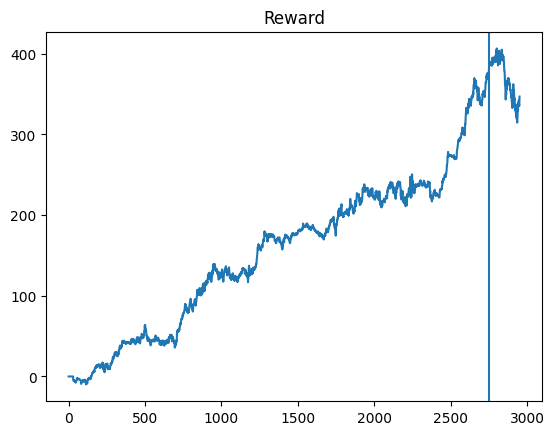

Epoch 1 ... 0.016141080088170404 ... reg 188.4669
Epoch 2 ... 0.05032801983835422 ... reg 192.01537
Epoch 3 ... 0.010676307861866323 ... reg 198.61191
Epoch 4 ... 0.047010253490080846 ... reg 204.42345
Epoch 5 ... 0.04870583761939759 ... reg 212.2478
Epoch 6 ... 0.040767421013960435 ... reg 212.33449
Epoch 7 ... 0.04328510653930931 ... reg 218.72375
Epoch 8 ... 0.03837084864070531 ... reg 219.36047
Epoch 9 ... -0.0034462196914033265 ... reg 223.9283
Epoch 10 ... 0.041651914033798705 ... reg 225.06732


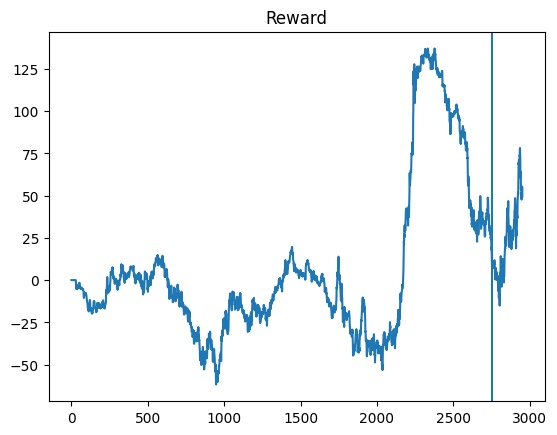

Epoch 11 ... 0.06358440484937543 ... reg 235.57668
Epoch 12 ... 0.07102368846436441 ... reg 238.19444
Epoch 13 ... 0.11278937545922121 ... reg 241.89546
Epoch 14 ... 0.08838691036002942 ... reg 247.51791
Epoch 15 ... 0.09411592946362975 ... reg 251.7748
Epoch 16 ... 0.08078247244673051 ... reg 253.72449
Epoch 17 ... 0.08402316678912565 ... reg 257.71088
Epoch 18 ... 0.06513685525349008 ... reg 257.70862
Epoch 19 ... 0.08811165319617924 ... reg 264.01547
Epoch 20 ... 0.09018892725936811 ... reg 267.99512


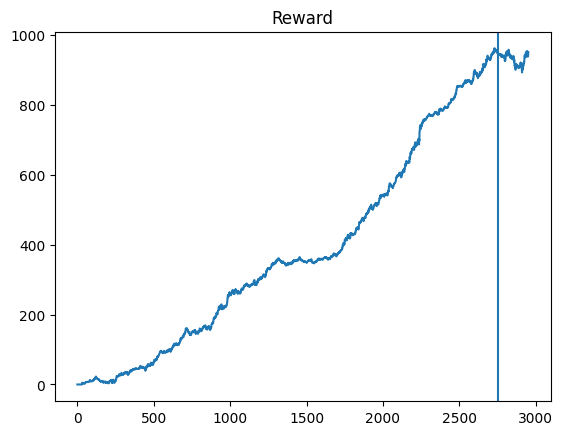

Epoch 21 ... 0.10001377296105804 ... reg 268.80093
Epoch 22 ... 0.13775703526818514 ... reg 273.14886
Epoch 23 ... 0.10267826230712715 ... reg 275.11432
Epoch 24 ... 0.1043334753857457 ... reg 280.58795
Epoch 25 ... 0.044250341660543695 ... reg 277.7302
Epoch 26 ... 0.13693493387215278 ... reg 283.06042
Epoch 27 ... 0.11775868479059515 ... reg 292.7934
Epoch 28 ... 0.11670536737692865 ... reg 297.2574
Epoch 29 ... 0.12691924320352677 ... reg 297.67242
Epoch 30 ... 0.1434456833210874 ... reg 303.5006


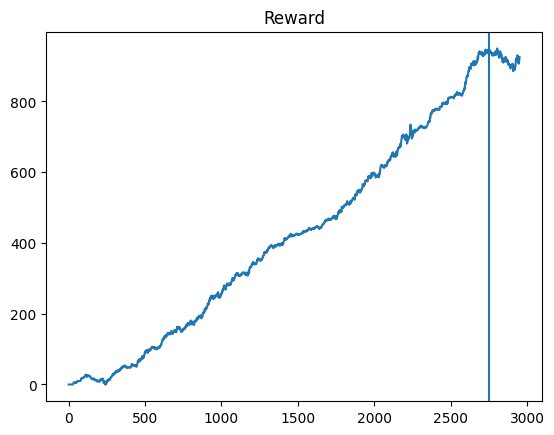

Epoch 31 ... 0.14188589272593677 ... reg 304.57736
Epoch 32 ... 0.14493207200587793 ... reg 305.2242
Epoch 33 ... 0.15444862968405568 ... reg 306.88785
Epoch 34 ... 0.10315904481998521 ... reg 307.25888
Epoch 35 ... 0.12639441954445257 ... reg 310.31537
Epoch 36 ... 0.1567094085231447 ... reg 310.80518
Epoch 37 ... 0.11840829169728145 ... reg 312.4858
Epoch 38 ... 0.1552487105069801 ... reg 314.12766
Epoch 39 ... 0.14284378765613517 ... reg 316.75034
Epoch 40 ... 0.10979824761204986 ... reg 317.67984


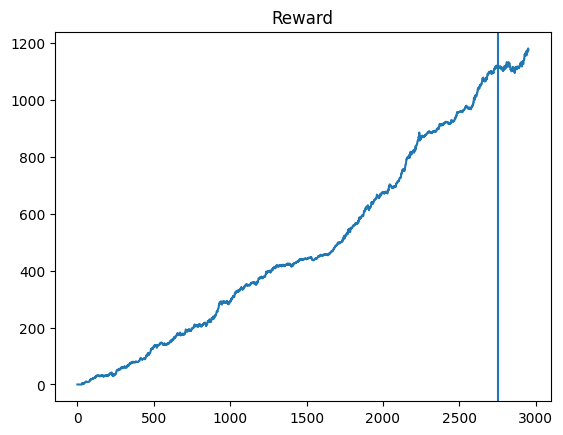

Epoch 41 ... 0.16455974283614988 ... reg 319.43716
Epoch 42 ... 0.12720918074944892 ... reg 320.85217
Epoch 43 ... 0.11793117927994111 ... reg 321.8959
Epoch 44 ... 0.15888210506980158 ... reg 326.7916
Epoch 45 ... 0.1634587141807494 ... reg 327.86472
Epoch 46 ... 0.16900422850844962 ... reg 329.68677
Epoch 47 ... 0.1565589346069067 ... reg 332.0185
Epoch 48 ... 0.15813707567964733 ... reg 333.99054
Epoch 49 ... 0.15405959955914772 ... reg 337.9267
Epoch 50 ... 0.1606914621601764 ... reg 340.75775


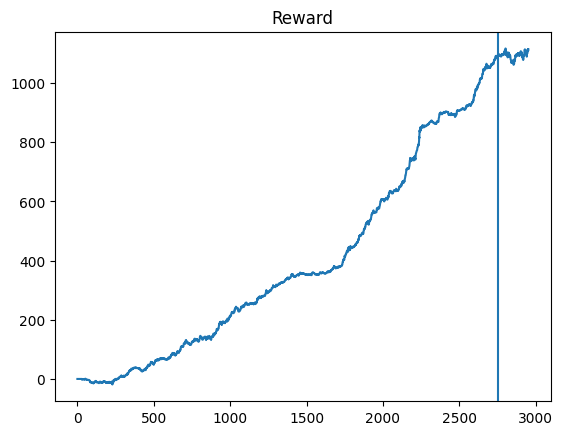

Epoch 51 ... 0.15266496326230722 ... reg 343.20248
Epoch 52 ... 0.1832698897869214 ... reg 346.83075
Epoch 53 ... 0.13338228141072736 ... reg 347.84818
Epoch 54 ... 0.16319813739897127 ... reg 351.55643
Epoch 55 ... 0.17739039676708304 ... reg 352.18314
Epoch 56 ... 0.14573582292432036 ... reg 352.43326
Epoch 57 ... 0.1832074981631154 ... reg 354.35876
Epoch 58 ... 0.19066146216017626 ... reg 356.18552
Epoch 59 ... 0.15792054004408526 ... reg 355.86603
Epoch 60 ... 0.155021164584864 ... reg 357.08707


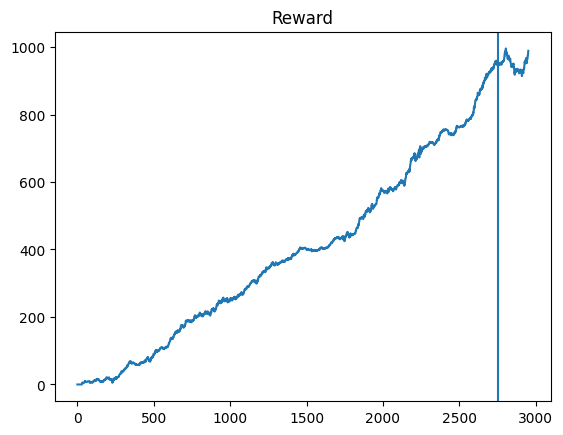

Epoch 61 ... 0.19823286921381333 ... reg 359.1839
Epoch 62 ... 0.16672509919177067 ... reg 361.2228
Epoch 63 ... 0.1924120977222631 ... reg 365.76138
Epoch 64 ... 0.16326052902277743 ... reg 366.79132
Epoch 65 ... 0.17278075679647317 ... reg 366.87766
Epoch 66 ... 0.1517254188096988 ... reg 368.34412
Epoch 67 ... 0.17606549228508453 ... reg 369.73587
Epoch 68 ... 0.17673344966936075 ... reg 372.02237
Epoch 69 ... 0.18654728508449675 ... reg 375.04953
Epoch 70 ... 0.19044125642909626 ... reg 374.934


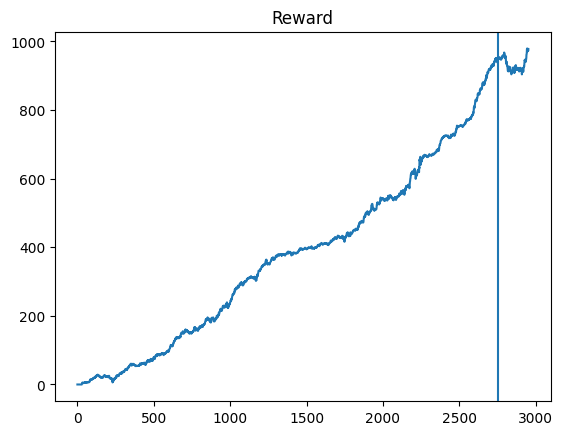

Epoch 71 ... 0.16693429463629691 ... reg 375.83112
Epoch 72 ... 0.1960344819985305 ... reg 379.82086
Epoch 73 ... 0.17373498163115364 ... reg 381.33902
Epoch 74 ... 0.1744469801616458 ... reg 383.10367
Epoch 75 ... 0.1748323401910361 ... reg 384.45544
Epoch 76 ... 0.18945400073475388 ... reg 387.15704
Epoch 77 ... 0.17238805657604714 ... reg 387.3095
Epoch 78 ... 0.1859784202792065 ... reg 389.0474
Epoch 79 ... 0.15571481263776635 ... reg 390.6967
Epoch 80 ... 0.19343605437178538 ... reg 392.36014


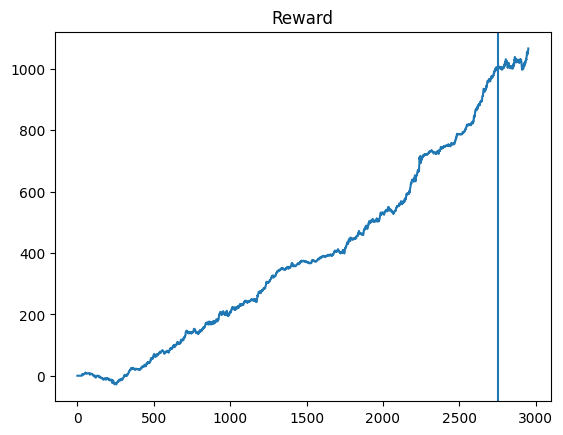

Epoch 81 ... 0.19796128214548125 ... reg 394.35602
Epoch 82 ... 0.1977300661278472 ... reg 396.80402
Epoch 83 ... 0.1940636407053637 ... reg 397.74744
Epoch 84 ... 0.18128436811168264 ... reg 398.60632
Epoch 85 ... 0.1931534570168994 ... reg 399.7316
Epoch 86 ... 0.17404326965466568 ... reg 401.42963
Epoch 87 ... 0.21346376561351954 ... reg 403.6025
Epoch 88 ... 0.20605017266715653 ... reg 404.99393
Epoch 89 ... 0.19338834313005146 ... reg 405.94144
Epoch 90 ... 0.2127003857457752 ... reg 409.08533


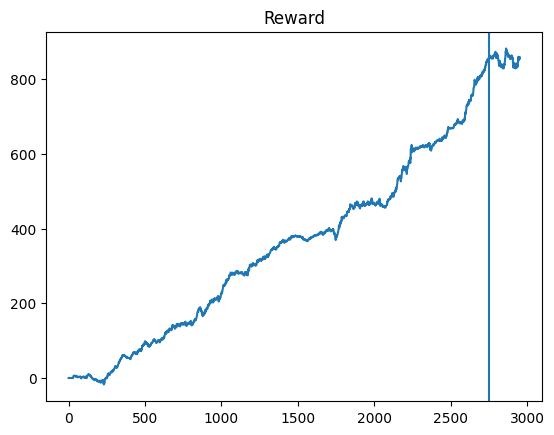

Epoch 91 ... 0.19172578986039682 ... reg 410.97705
Epoch 92 ... 0.18671977957384284 ... reg 412.69415
Epoch 93 ... 0.17624532696546658 ... reg 413.82623
Epoch 94 ... 0.18476361866274796 ... reg 416.35782
Epoch 95 ... 0.1849728141072741 ... reg 418.3203
Epoch 96 ... 0.18461314474651 ... reg 419.13156
Epoch 97 ... 0.19548763776634828 ... reg 421.36307
Epoch 98 ... 0.19744012858192508 ... reg 421.81326
Epoch 99 ... 0.17467085598824397 ... reg 422.191
Epoch 100 ... 0.1760691623806025 ... reg 405.4223


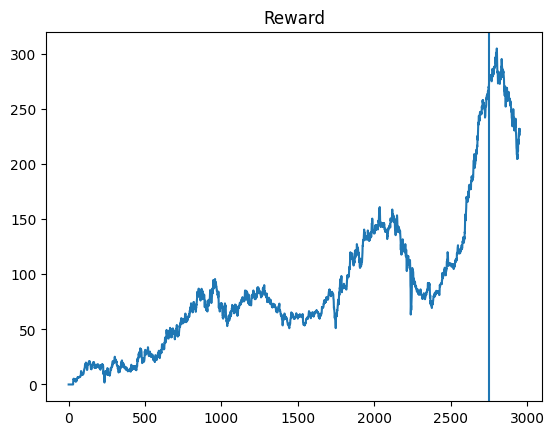

Epoch 101 ... 0.1627797465099192 ... reg 378.41434
Epoch 102 ... 0.17946033063923583 ... reg 356.5135
Epoch 103 ... 0.1851379684055841 ... reg 334.61746
Epoch 104 ... 0.16798027185892725 ... reg 315.343
Epoch 105 ... 0.18763363335782512 ... reg 297.5906
Epoch 106 ... 0.19352046656869956 ... reg 281.45453
Epoch 107 ... 0.1881878177810434 ... reg 267.92377
Epoch 108 ... 0.17523238060249818 ... reg 254.32622
Epoch 109 ... 0.17462681484202797 ... reg 241.37793
Epoch 110 ... 0.16540753490080823 ... reg 229.3415


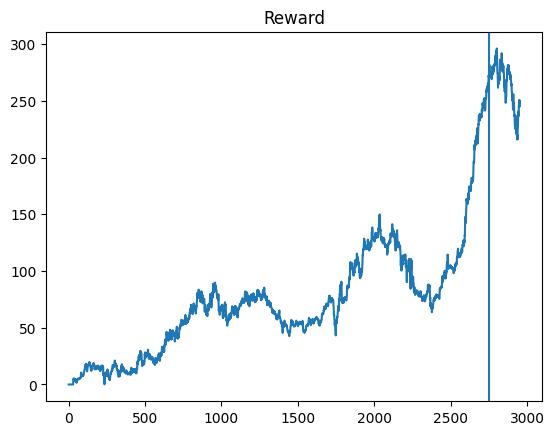

Epoch 111 ... 0.17329090007347545 ... reg 219.73175
Epoch 112 ... 0.1856407714915503 ... reg 209.81757
Epoch 113 ... 0.16368626010286552 ... reg 198.00458
Epoch 114 ... 0.1502170095518001 ... reg 188.31686
Epoch 115 ... 0.13500813372520207 ... reg 180.06778
Epoch 116 ... 0.14284745775165308 ... reg 168.81372
Epoch 117 ... 0.12463644379132986 ... reg 160.37756
Epoch 118 ... 0.13817542615723724 ... reg 149.67833
Epoch 119 ... 0.14914167156502567 ... reg 142.77904
Epoch 120 ... 0.13590730712711235 ... reg 136.28426


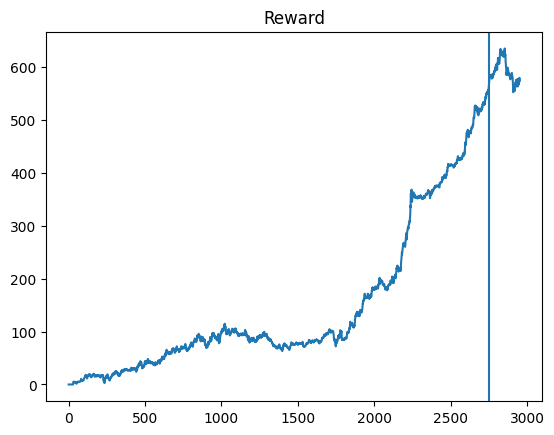

Epoch 121 ... 0.09204599559147679 ... reg 127.863754
Epoch 122 ... 0.12463644379132982 ... reg 122.773926
Epoch 123 ... 0.07176137766348276 ... reg 119.41293
Epoch 124 ... 0.11427209404849369 ... reg 110.55827
Epoch 125 ... 0.11520429831006604 ... reg 106.08488
Epoch 126 ... 0.11625027553269648 ... reg 101.50847
Epoch 127 ... 0.1252860506980161 ... reg 97.835594
Epoch 128 ... 0.12423273328434974 ... reg 96.24215
Epoch 129 ... 0.14467883541513593 ... reg 93.69083
Epoch 130 ... 0.1294222483468038 ... reg 93.09836


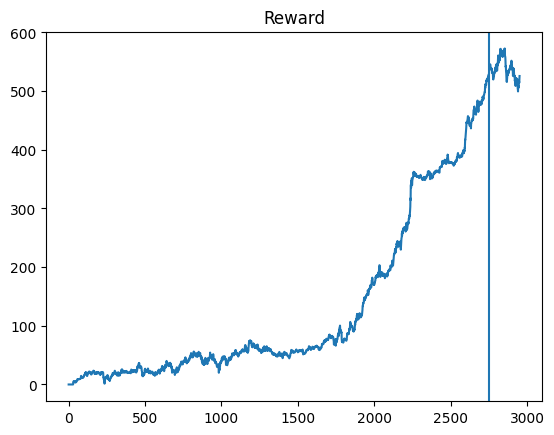

Epoch 131 ... 0.11604108008817043 ... reg 89.65447
Epoch 132 ... 0.13207939750183675 ... reg 88.10196
Epoch 133 ... 0.11316372520205722 ... reg 87.01445
Epoch 134 ... 0.14170238795003667 ... reg 86.5989
Epoch 135 ... 0.14835627112417332 ... reg 89.370224
Epoch 136 ... 0.14816175606171925 ... reg 88.25366
Epoch 137 ... 0.13933517634092574 ... reg 87.27273
Epoch 138 ... 0.15451102130786187 ... reg 87.54371
Epoch 139 ... 0.16292288023512116 ... reg 87.34608
Epoch 140 ... 0.15988037105069794 ... reg 85.98708


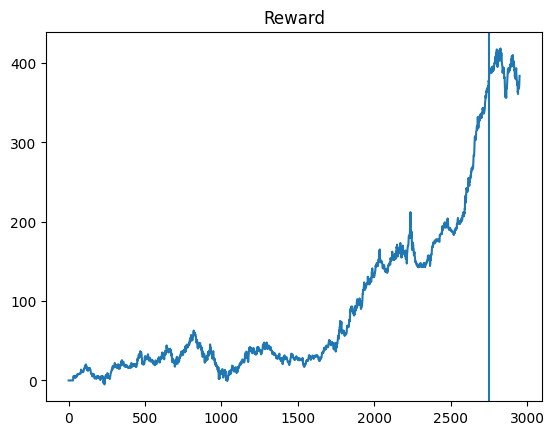

Epoch 141 ... 0.14602576047024238 ... reg 85.453
Epoch 142 ... 0.14873796105804557 ... reg 84.38587
Epoch 143 ... 0.1567938207200588 ... reg 86.97485
Epoch 144 ... 0.15956474283614985 ... reg 84.51733
Epoch 145 ... 0.1627907567964732 ... reg 83.0868
Epoch 146 ... 0.16407896032329172 ... reg 83.46519
Epoch 147 ... 0.17101177075679644 ... reg 83.93669
Epoch 148 ... 0.15698099559147682 ... reg 84.91334
Epoch 149 ... 0.15713880969875088 ... reg 84.74477
Epoch 150 ... 0.14708641807494485 ... reg 84.22913


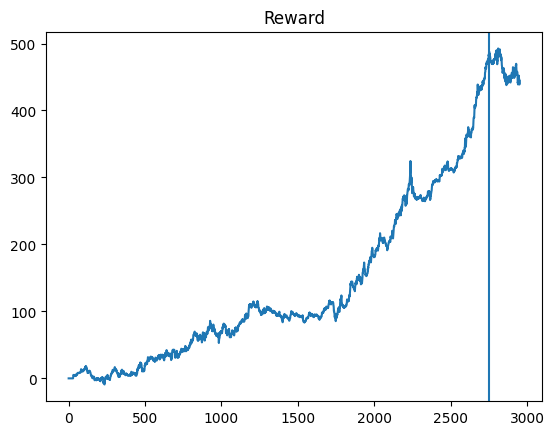

Epoch 151 ... 0.152470448199853 ... reg 83.53561
Epoch 152 ... 0.13899752755326955 ... reg 84.60106
Epoch 153 ... 0.14587895664952236 ... reg 82.40578
Epoch 154 ... 0.15040051432770013 ... reg 84.89242
Epoch 155 ... 0.15539551432770013 ... reg 84.171295
Epoch 156 ... 0.15249980896399692 ... reg 80.36626
Epoch 157 ... 0.14256119030124897 ... reg 77.208145
Epoch 158 ... 0.1328537876561352 ... reg 80.61754
Epoch 159 ... 0.15567444158706828 ... reg 76.98391
Epoch 160 ... 0.14562572005878024 ... reg 79.198105


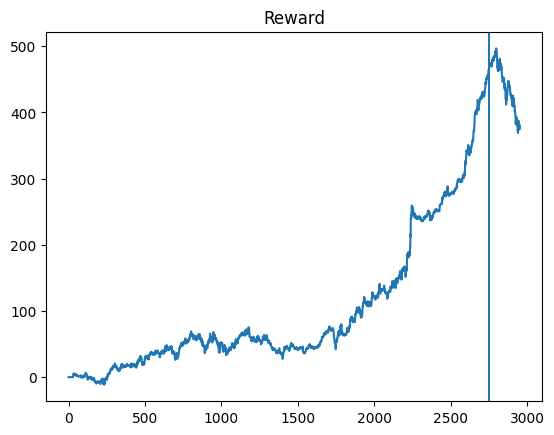

Epoch 161 ... 0.15387242468772952 ... reg 82.079895
Epoch 162 ... 0.15925645481263764 ... reg 76.95111
Epoch 163 ... 0.15942527920646574 ... reg 79.407036
Epoch 164 ... 0.1672682733284349 ... reg 79.32097
Epoch 165 ... 0.15449634092578982 ... reg 76.41953
Epoch 166 ... 0.15559002939015418 ... reg 74.75394
Epoch 167 ... 0.1654919470977222 ... reg 75.427704
Epoch 168 ... 0.16630303820720055 ... reg 74.78815
Epoch 169 ... 0.1527934166054371 ... reg 76.2009
Epoch 170 ... 0.1538357237325495 ... reg 74.82916


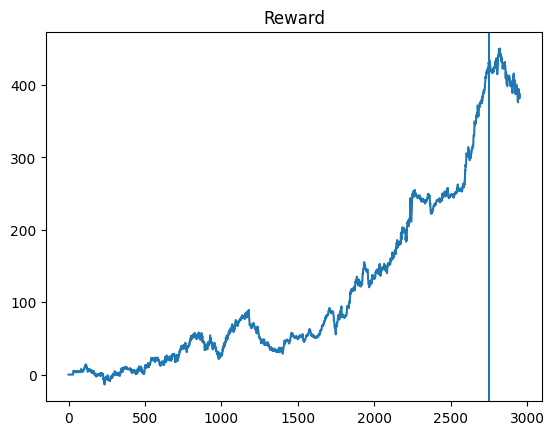

Epoch 171 ... 0.1505142872887582 ... reg 75.893906
Epoch 172 ... 0.15099139970609837 ... reg 73.81867
Epoch 173 ... 0.1540559294636296 ... reg 77.65255
Epoch 174 ... 0.1540816201322556 ... reg 78.40674
Epoch 175 ... 0.1723366752387949 ... reg 74.48427
Epoch 176 ... 0.16711045922116083 ... reg 76.91427
Epoch 177 ... 0.1585150955180014 ... reg 75.08204
Epoch 178 ... 0.17675180014695063 ... reg 73.50662
Epoch 179 ... 0.16515796840558403 ... reg 72.233986
Epoch 180 ... 0.16035381337252008 ... reg 73.03713


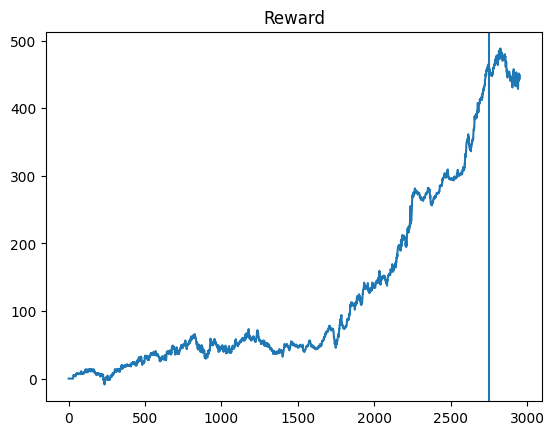

Epoch 181 ... 0.1756948126377663 ... reg 72.15088
Epoch 182 ... 0.1640679500367377 ... reg 72.35783
Epoch 183 ... 0.17231832476120493 ... reg 73.43176
Epoch 184 ... 0.18233034533431294 ... reg 79.01471
Epoch 185 ... 0.16940793901542975 ... reg 79.75901
Epoch 186 ... 0.1640349191770756 ... reg 73.61914
Epoch 187 ... 0.16577821454812627 ... reg 74.09009
Epoch 188 ... 0.17937591844232176 ... reg 72.30253
Epoch 189 ... 0.17384508449669347 ... reg 71.74612
Epoch 190 ... 0.15819579720793528 ... reg 71.66098


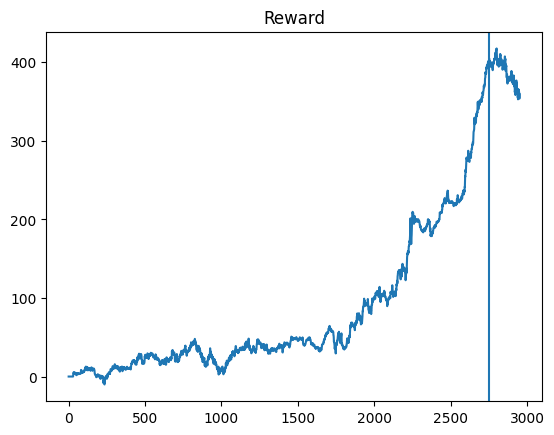

Epoch 191 ... 0.16012626745040404 ... reg 73.158165
Epoch 192 ... 0.17348174504041142 ... reg 72.324066
Epoch 193 ... 0.16033546289493014 ... reg 73.04088
Epoch 194 ... 0.16093368846436445 ... reg 71.54003
Epoch 195 ... 0.16185855253490072 ... reg 71.63492
Epoch 196 ... 0.16926480529022775 ... reg 70.611534
Epoch 197 ... 0.1606988023512123 ... reg 71.3614
Epoch 198 ... 0.15578454445260834 ... reg 72.19951
Epoch 199 ... 0.17227795371050694 ... reg 72.275406
Epoch 200 ... 0.15318978692138133 ... reg 70.778786


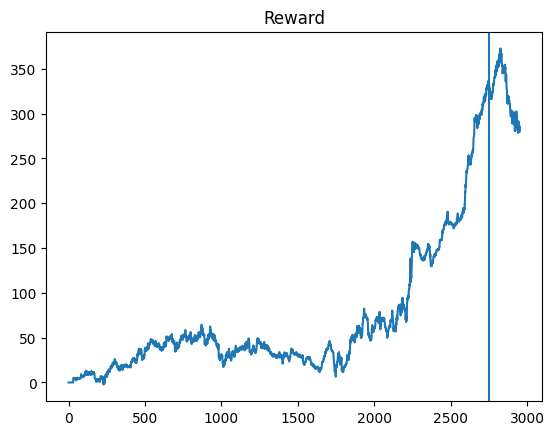

Epoch 201 ... 0.16951437178545184 ... reg 72.3219
Epoch 202 ... 0.16628468772961053 ... reg 72.60943
Epoch 203 ... 0.17271836517266717 ... reg 72.64792
Epoch 204 ... 0.1666076561351947 ... reg 71.54377
Epoch 205 ... 0.16408630051432763 ... reg 74.299194
Epoch 206 ... 0.1709493791329904 ... reg 72.396805
Epoch 207 ... 0.17410933137398965 ... reg 73.05394
Epoch 208 ... 0.1588821050698016 ... reg 71.99331
Epoch 209 ... 0.17366157972079344 ... reg 71.33142
Epoch 210 ... 0.16008589639970602 ... reg 70.17665


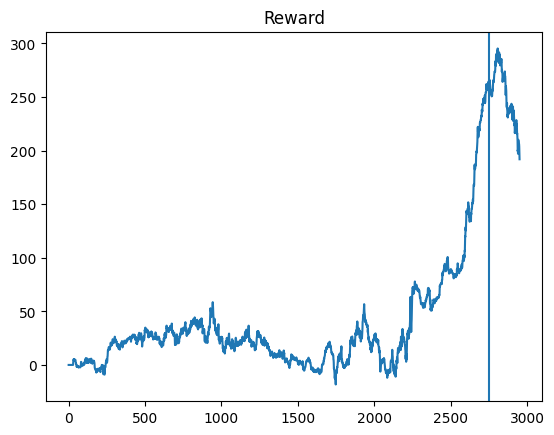

Epoch 211 ... 0.17957410360029386 ... reg 72.22307
Epoch 212 ... 0.17245411829537102 ... reg 69.90696
Epoch 213 ... 0.17339733284349734 ... reg 70.42603
Epoch 214 ... 0.1605152975753122 ... reg 70.158134
Epoch 215 ... 0.16332659074210132 ... reg 68.61178
Epoch 216 ... 0.1717971711976487 ... reg 67.827805
Epoch 217 ... 0.14906826965466566 ... reg 68.22676
Epoch 218 ... 0.16822249816311527 ... reg 65.29924
Epoch 219 ... 0.18091368846436442 ... reg 67.85488
Epoch 220 ... 0.1646478251285819 ... reg 67.278564


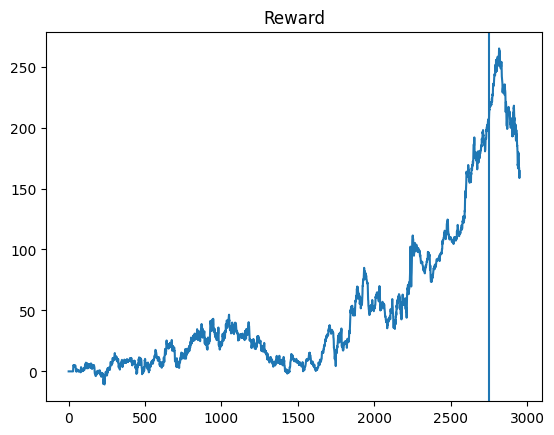

Epoch 221 ... 0.1534173328434974 ... reg 65.23625
Epoch 222 ... 0.1513804298310066 ... reg 64.5183
Epoch 223 ... 0.14917103232916973 ... reg 64.111664
Epoch 224 ... 0.15313473548861128 ... reg 64.185585
Epoch 225 ... 0.16468819617928002 ... reg 64.12046
Epoch 226 ... 0.1438530639235856 ... reg 64.18719
Epoch 227 ... 0.15327052902277744 ... reg 62.11644
Epoch 228 ... 0.1552413703159442 ... reg 61.86909
Epoch 229 ... 0.14456139235855991 ... reg 61.8664
Epoch 230 ... 0.15348339456282148 ... reg 60.67558


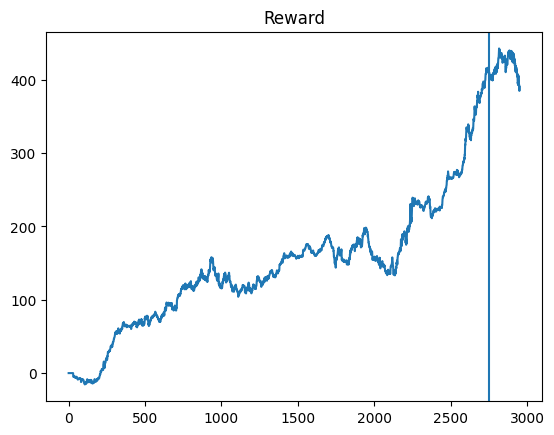

Epoch 231 ... 0.16010791697281415 ... reg 60.621906
Epoch 232 ... 0.1552266899338722 ... reg 60.358395
Epoch 233 ... 0.16900055841293174 ... reg 58.946133
Epoch 234 ... 0.16357615723732555 ... reg 58.542507
Epoch 235 ... 0.1612823475385746 ... reg 58.015774
Epoch 236 ... 0.17079523512123443 ... reg 58.21114
Epoch 237 ... 0.18670142909625284 ... reg 58.233574
Epoch 238 ... 0.17652792432035272 ... reg 58.585903
Epoch 239 ... 0.18415438280675978 ... reg 57.691555
Epoch 240 ... 0.1848884019103601 ... reg 58.167007


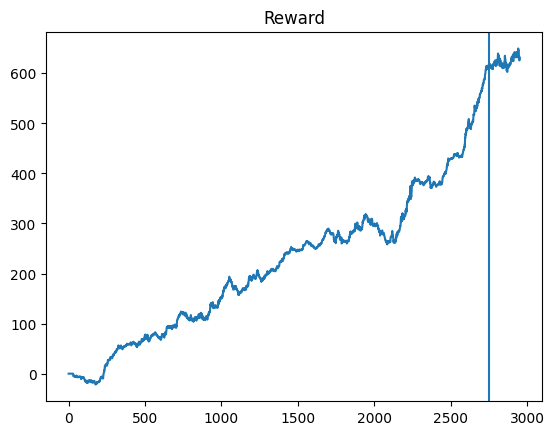

Epoch 241 ... 0.1713200587803086 ... reg 57.559383
Epoch 242 ... 0.17787117927994125 ... reg 57.089546
Epoch 243 ... 0.17102645113886852 ... reg 57.417583
Epoch 244 ... 0.16359450771491554 ... reg 56.63987
Epoch 245 ... 0.17373498163115353 ... reg 57.499363
Epoch 246 ... 0.1785501469507715 ... reg 58.19941
Epoch 247 ... 0.18023472079353414 ... reg 56.894455
Epoch 248 ... 0.17963282512858195 ... reg 57.95853
Epoch 249 ... 0.17689860396767088 ... reg 57.179626
Epoch 250 ... 0.17117692505510654 ... reg 55.913334


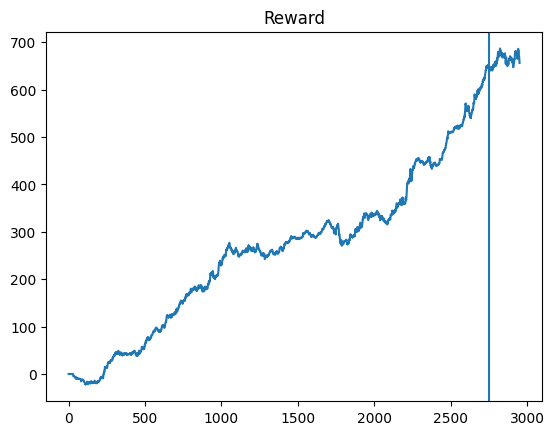

Epoch 251 ... 0.1718045113886848 ... reg 57.116642
Epoch 252 ... 0.17809872520205733 ... reg 55.987736
Epoch 253 ... 0.16521301983835418 ... reg 56.163
Epoch 254 ... 0.16512860764144013 ... reg 54.954586
Epoch 255 ... 0.1759040080822925 ... reg 55.144817
Epoch 256 ... 0.1734597244673035 ... reg 55.560677
Epoch 257 ... 0.1653524834680382 ... reg 55.769524
Epoch 258 ... 0.1765352645113887 ... reg 55.308216
Epoch 259 ... 0.172123809698751 ... reg 55.76734
Epoch 260 ... 0.1893182072005878 ... reg 55.889893


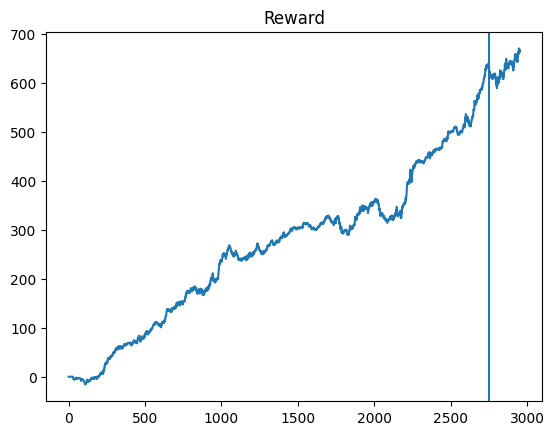

Epoch 261 ... 0.179827340191036 ... reg 56.045494
Epoch 262 ... 0.17340467303453344 ... reg 56.19766
Epoch 263 ... 0.17997781410727404 ... reg 56.315613
Epoch 264 ... 0.16791054004408523 ... reg 55.849037
Epoch 265 ... 0.17943463997060982 ... reg 55.954617
Epoch 266 ... 0.17589299779573844 ... reg 55.96876
Epoch 267 ... 0.17186323291697284 ... reg 55.76682
Epoch 268 ... 0.17531312270389418 ... reg 55.77895
Epoch 269 ... 0.17807670462894934 ... reg 56.47689
Epoch 270 ... 0.16473957751653198 ... reg 55.694374


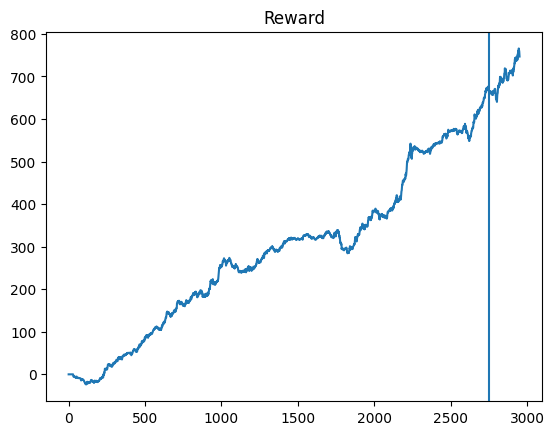

Epoch 271 ... 0.17556268919911833 ... reg 55.735992
Epoch 272 ... 0.1755223181484203 ... reg 55.47348
Epoch 273 ... 0.18185690301249083 ... reg 55.835865
Epoch 274 ... 0.18086230712711243 ... reg 56.060837
Epoch 275 ... 0.1779005400440852 ... reg 56.46484
Epoch 276 ... 0.18554534900808228 ... reg 56.489204
Epoch 277 ... 0.1851012674504041 ... reg 56.277378
Epoch 278 ... 0.1925442211609111 ... reg 56.257034
Epoch 279 ... 0.18093203894195442 ... reg 56.388496
Epoch 280 ... 0.1862096362968406 ... reg 55.852085


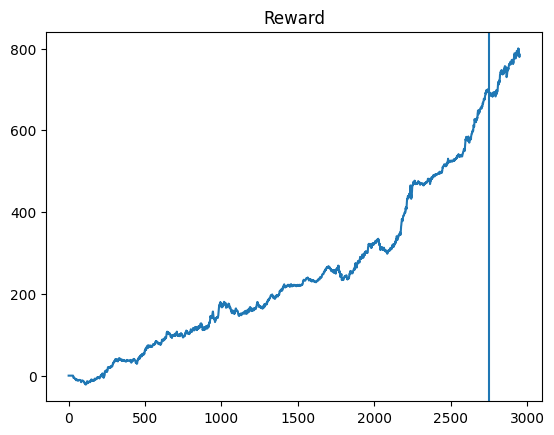

Epoch 281 ... 0.18738039676708304 ... reg 55.706818
Epoch 282 ... 0.1887309919177076 ... reg 56.432545
Epoch 283 ... 0.18423145481263775 ... reg 56.073383
Epoch 284 ... 0.17327254959588537 ... reg 56.369064
Epoch 285 ... 0.18068614254224838 ... reg 56.370464
Epoch 286 ... 0.17309638501102137 ... reg 55.941147
Epoch 287 ... 0.17961080455547393 ... reg 56.469448
Epoch 288 ... 0.19088166789125646 ... reg 56.201206
Epoch 289 ... 0.17947134092578984 ... reg 56.677635
Epoch 290 ... 0.18427916605437178 ... reg 57.050453


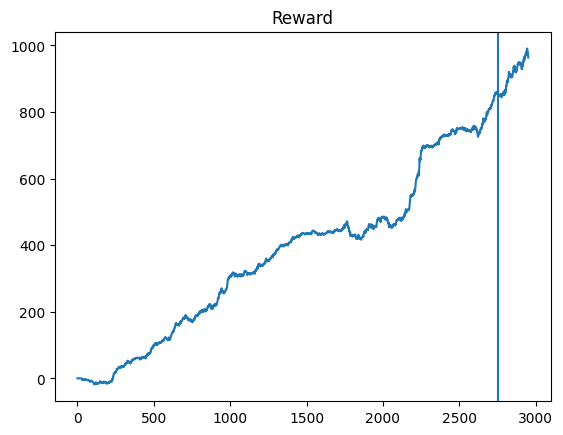

Epoch 291 ... 0.19309840558412933 ... reg 57.776028
Epoch 292 ... 0.18354881704628953 ... reg 59.13882
Epoch 293 ... 0.16960979426891992 ... reg 58.297276
Epoch 294 ... 0.18393050698016167 ... reg 58.73314
Epoch 295 ... 0.17883641440117565 ... reg 59.73261
Epoch 296 ... 0.19938160911094785 ... reg 59.360138
Epoch 297 ... 0.1961042138133726 ... reg 59.12485
Epoch 298 ... 0.1888521050698017 ... reg 59.277966
Epoch 299 ... 0.1879309110947833 ... reg 59.0957
Epoch 300 ... 0.18728497428361504 ... reg 59.468163


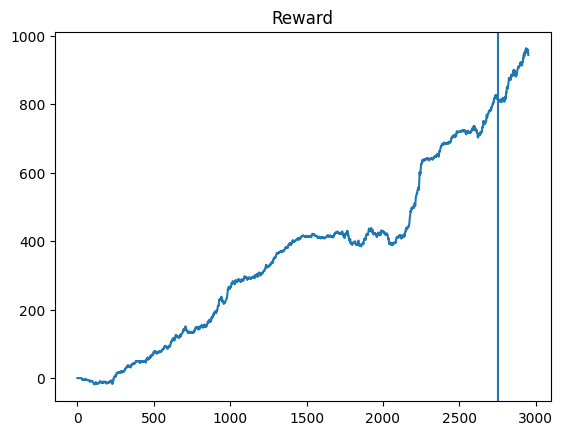

Epoch 301 ... 0.18626468772961066 ... reg 59.12242
Epoch 302 ... 0.18535450404114628 ... reg 59.08947
Epoch 303 ... 0.19240842762674512 ... reg 59.321346
Epoch 304 ... 0.18676015062454085 ... reg 59.545208
Epoch 305 ... 0.18686658339456289 ... reg 59.645985
Epoch 306 ... 0.18580225569434247 ... reg 59.99715
Epoch 307 ... 0.19971925789860404 ... reg 59.691193
Epoch 308 ... 0.1855967303453344 ... reg 60.494495
Epoch 309 ... 0.18573252387950046 ... reg 59.845062
Epoch 310 ... 0.1785354665686996 ... reg 60.468575


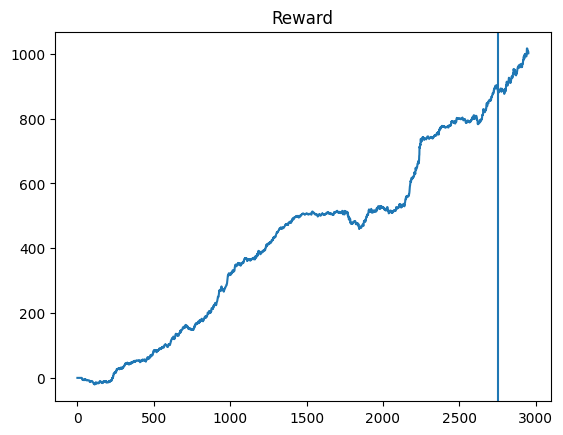

Epoch 311 ... 0.1932635598824395 ... reg 59.11353
Epoch 312 ... 0.18482234019103616 ... reg 59.170387
Epoch 313 ... 0.1790052387950038 ... reg 58.73116
Epoch 314 ... 0.17817212711241745 ... reg 59.14813
Epoch 315 ... 0.1916193570903748 ... reg 58.3886
Epoch 316 ... 0.18408832108743584 ... reg 57.67078
Epoch 317 ... 0.179515382072006 ... reg 58.013695
Epoch 318 ... 0.1764692027920648 ... reg 57.450806
Epoch 319 ... 0.18306436443791338 ... reg 57.399822
Epoch 320 ... 0.17609852314474664 ... reg 57.284424


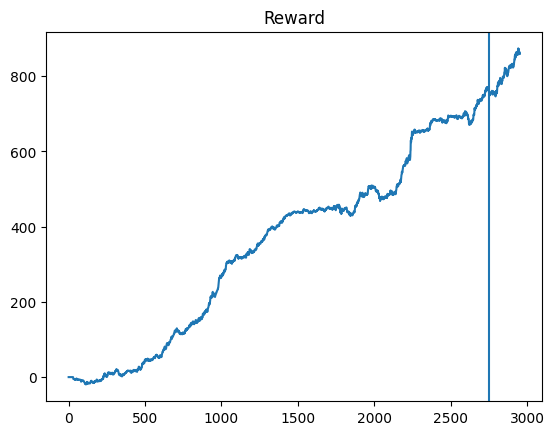

Epoch 321 ... 0.17493143277002213 ... reg 57.375893
Epoch 322 ... 0.1700722263041882 ... reg 56.69396
Epoch 323 ... 0.17184121234386487 ... reg 56.734344
Epoch 324 ... 0.17181185157972093 ... reg 56.675472
Epoch 325 ... 0.17675547024246885 ... reg 56.72514
Epoch 326 ... 0.19022105069801626 ... reg 56.291233
Epoch 327 ... 0.17039519470977224 ... reg 56.635532
Epoch 328 ... 0.1693712380602499 ... reg 56.33792
Epoch 329 ... 0.1724541182953711 ... reg 56.28409
Epoch 330 ... 0.16858950771491557 ... reg 57.092144


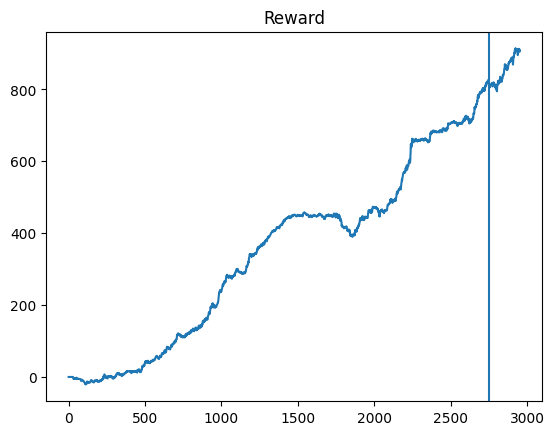

Epoch 331 ... 0.1640826304188098 ... reg 57.806904
Epoch 332 ... 0.17125766715650265 ... reg 57.38511
Epoch 333 ... 0.16891981631153566 ... reg 57.76062
Epoch 334 ... 0.17283213813372525 ... reg 57.75831
Epoch 335 ... 0.16976760837619403 ... reg 58.009686
Epoch 336 ... 0.16901156869948575 ... reg 57.898186
Epoch 337 ... 0.16755087068332108 ... reg 57.692562
Epoch 338 ... 0.16955841293166793 ... reg 58.213703
Epoch 339 ... 0.17120261572373258 ... reg 58.956806
Epoch 340 ... 0.17357349742836153 ... reg 58.461964


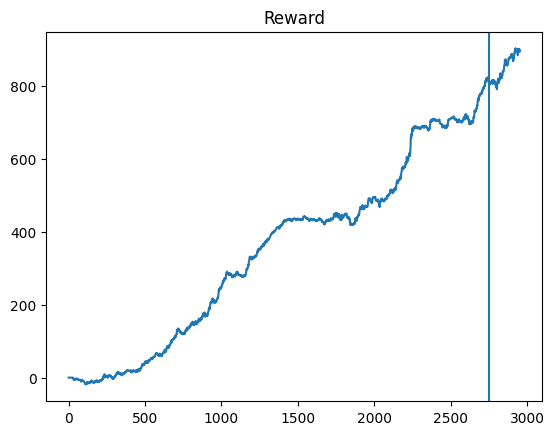

Epoch 341 ... 0.17169440852314477 ... reg 58.280064
Epoch 342 ... 0.1651542983100662 ... reg 58.681076
Epoch 343 ... 0.16919874357090378 ... reg 59.3092
Epoch 344 ... 0.1754305657604703 ... reg 59.2538
Epoch 345 ... 0.17533147318148423 ... reg 59.809032
Epoch 346 ... 0.17849142542248347 ... reg 60.105885
Epoch 347 ... 0.17463048493754593 ... reg 60.128506
Epoch 348 ... 0.17022270022042618 ... reg 60.207855
Epoch 349 ... 0.1813137288758267 ... reg 60.612843
Epoch 350 ... 0.17450203159441594 ... reg 60.66695


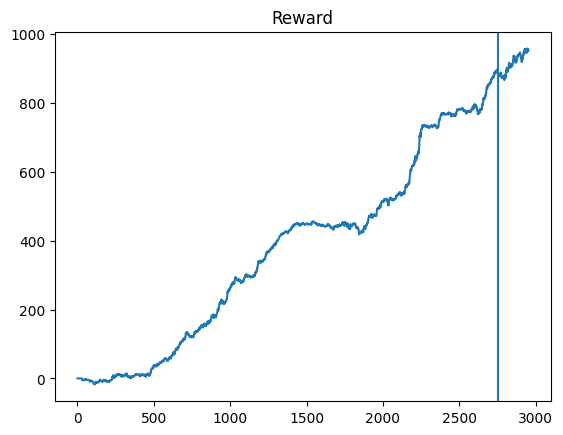

Epoch 351 ... 0.17357349742836156 ... reg 60.985855
Epoch 352 ... 0.1869253049228509 ... reg 60.665245
Epoch 353 ... 0.17787484937545925 ... reg 60.240868
Epoch 354 ... 0.18660233651726676 ... reg 61.05519
Epoch 355 ... 0.1856187509184424 ... reg 61.649136
Epoch 356 ... 0.1901146179279942 ... reg 62.074635
Epoch 357 ... 0.18968521675238806 ... reg 61.72257
Epoch 358 ... 0.18268267450404124 ... reg 61.978302
Epoch 359 ... 0.1880813850110214 ... reg 62.00191
Epoch 360 ... 0.18721157237325503 ... reg 62.03321


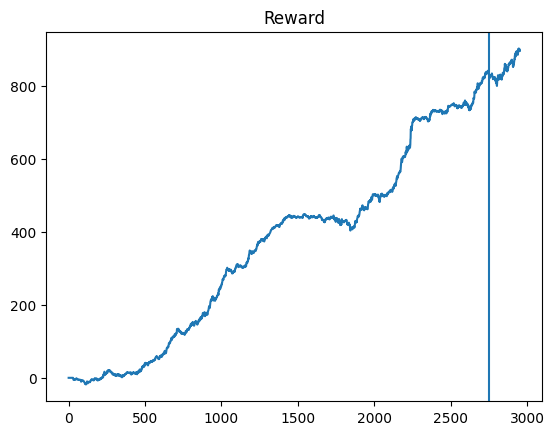

Epoch 361 ... 0.18639314107274074 ... reg 62.392418
Epoch 362 ... 0.1793318772961059 ... reg 62.138195
Epoch 363 ... 0.17881806392358565 ... reg 62.048344
Epoch 364 ... 0.18433054739162386 ... reg 61.953705
Epoch 365 ... 0.17940160911094793 ... reg 61.70731
Epoch 366 ... 0.1892337950036738 ... reg 62.029644
Epoch 367 ... 0.18321483835415142 ... reg 61.608414
Epoch 368 ... 0.19160467670830278 ... reg 61.496765
Epoch 369 ... 0.18415805290227777 ... reg 61.602417
Epoch 370 ... 0.18742810800881712 ... reg 62.094055


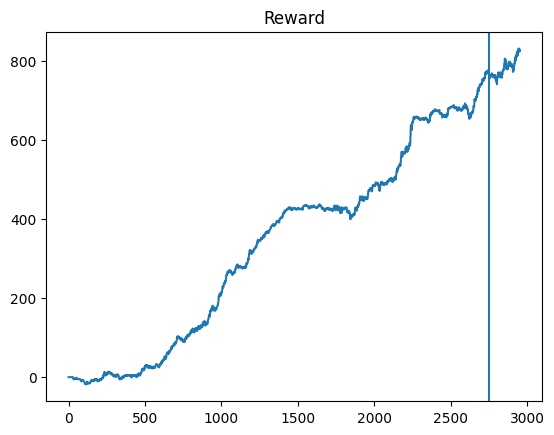

Epoch 371 ... 0.17830058045554745 ... reg 62.51234
Epoch 372 ... 0.18783548861131527 ... reg 62.618652
Epoch 373 ... 0.1834900955180015 ... reg 62.985954
Epoch 374 ... 0.18430852681851584 ... reg 62.711716
Epoch 375 ... 0.18659866642174874 ... reg 62.998375
Epoch 376 ... 0.18269368479059522 ... reg 63.48548
Epoch 377 ... 0.18442963997060988 ... reg 63.07372
Epoch 378 ... 0.187028067597355 ... reg 63.058502
Epoch 379 ... 0.18413970242468775 ... reg 63.37896
Epoch 380 ... 0.1815632953710508 ... reg 62.953636


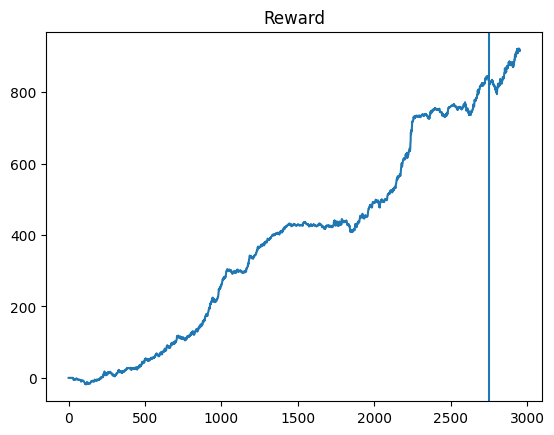

Epoch 381 ... 0.1860665025716386 ... reg 63.34177
Epoch 382 ... 0.18136144011756067 ... reg 63.30613
Epoch 383 ... 0.17258257163850116 ... reg 63.54276
Epoch 384 ... 0.1839415172667157 ... reg 63.204094
Epoch 385 ... 0.17867860029390165 ... reg 63.67397
Epoch 386 ... 0.19188727406318892 ... reg 64.14099
Epoch 387 ... 0.1803558339456283 ... reg 63.99615
Epoch 388 ... 0.1751112674504042 ... reg 63.811714
Epoch 389 ... 0.18135042983100666 ... reg 64.1872
Epoch 390 ... 0.18678584129316686 ... reg 64.89653


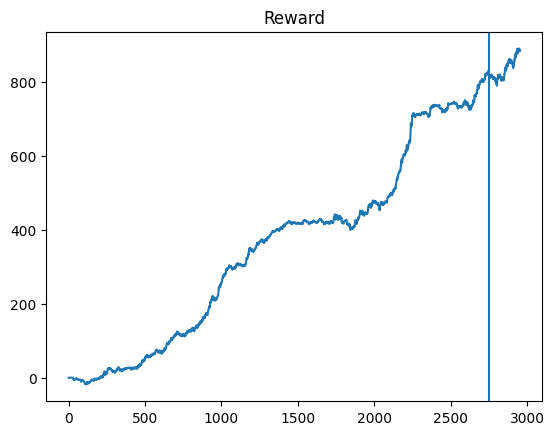

Epoch 391 ... 0.18082560617193247 ... reg 64.75178
Epoch 392 ... 0.18003653563556213 ... reg 64.41907
Epoch 393 ... 0.18285516899338725 ... reg 65.01593
Epoch 394 ... 0.17714817046289497 ... reg 65.27713
Epoch 395 ... 0.18360386847905957 ... reg 65.22653
Epoch 396 ... 0.17867860029390165 ... reg 65.86699
Epoch 397 ... 0.182154180749449 ... reg 66.19487
Epoch 398 ... 0.18606283247612063 ... reg 66.07992
Epoch 399 ... 0.17825286921381348 ... reg 66.04742


In [62]:
set_random_seed(42)
progress = []


for i in range(epochs):

    learning_progress = []
    reg = []
    for j in range(WINDOW_SHAPE, environment.train_length - REWARD_TIME, REWARD_TIME):
        print(f"{i} / {epochs} : {j} {DATASET_LENGTH - REWARD_TIME}", end='\r')

        # 1. Get the current state. Derivatives in a separate interval
        # The current Y on the graph and the previous WINDOW_SHAPE steps
        state_j = environment.get_state(j, WINDOW_SHAPE)
        # We get a prediction for this state through the model
        q_value_j = agent.get_value_action_value(state_j)

        # 2. Select an action for the current state
        # Depending on the length of the epsilon, we choose a random action
        # or real ones according to predictions
        if (np.random.random() < epsilon):
            action = np.random.randint(0, ACTIONS_SHAPE)
        else:
            action = np.argmax(q_value_j.detach().numpy())

        # 3. We receive a reward for the selected action
        reward_value_j = environment.get_reward(action, j, j + REWARD_TIME)
        learning_progress.append(reward_value_j)

        # 4. We get the future state. Derivatives in the future interval
        # The current Y + 1 on the graph and the previous WINDOW_SHAPE steps
        state_j_1 = environment.get_state(j + 1, WINDOW_SHAPE)

        # 5. We save all the received data of the agent
        agent.save_experience(state_j, action, reward_value_j, state_j_1)

        # 6. As soon as the number of previously received samples has exceeded
        # for what is necessary, we begin to train the network
        if j > 5*SAMPLE_SIZE:
            reg.append(agent.replay_experience(gamma, SAMPLE_SIZE,i).detach().numpy())

    # With each step, we decrease the epsilon so that the bot begins to act
    # according to his own forecasts, he stopped studying the environment
    epsilon = epsilon*alpha_e

    print('Epoch', i, '...', np.mean(learning_progress),'...','reg',np.mean(reg))
    progress.append(np.mean(learning_progress))
    learning_progress = []
    if i % 10 == 0:
      plot_ag()

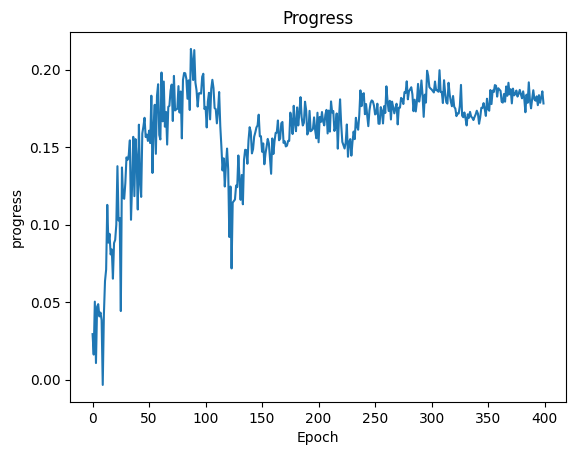

In [68]:
plt.title('Progress')
plt.xlabel('Epoch')
plt.ylabel('progress')
plt.plot(progress)

In [69]:
actions = []

for j in range(WINDOW_SHAPE, len(df['CLOSE']), REWARD_TIME):
    # 1. We obtain derivatives in a separate interval
    # Current price and previous WINDOW_SHAPE steps
    state_j = environment.get_state(j, WINDOW_SHAPE)

    # We get the prediction of the bot according to the data
    q_value_j = agent.get_value_action_value(state_j)
    # We define the signal and record it in events
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

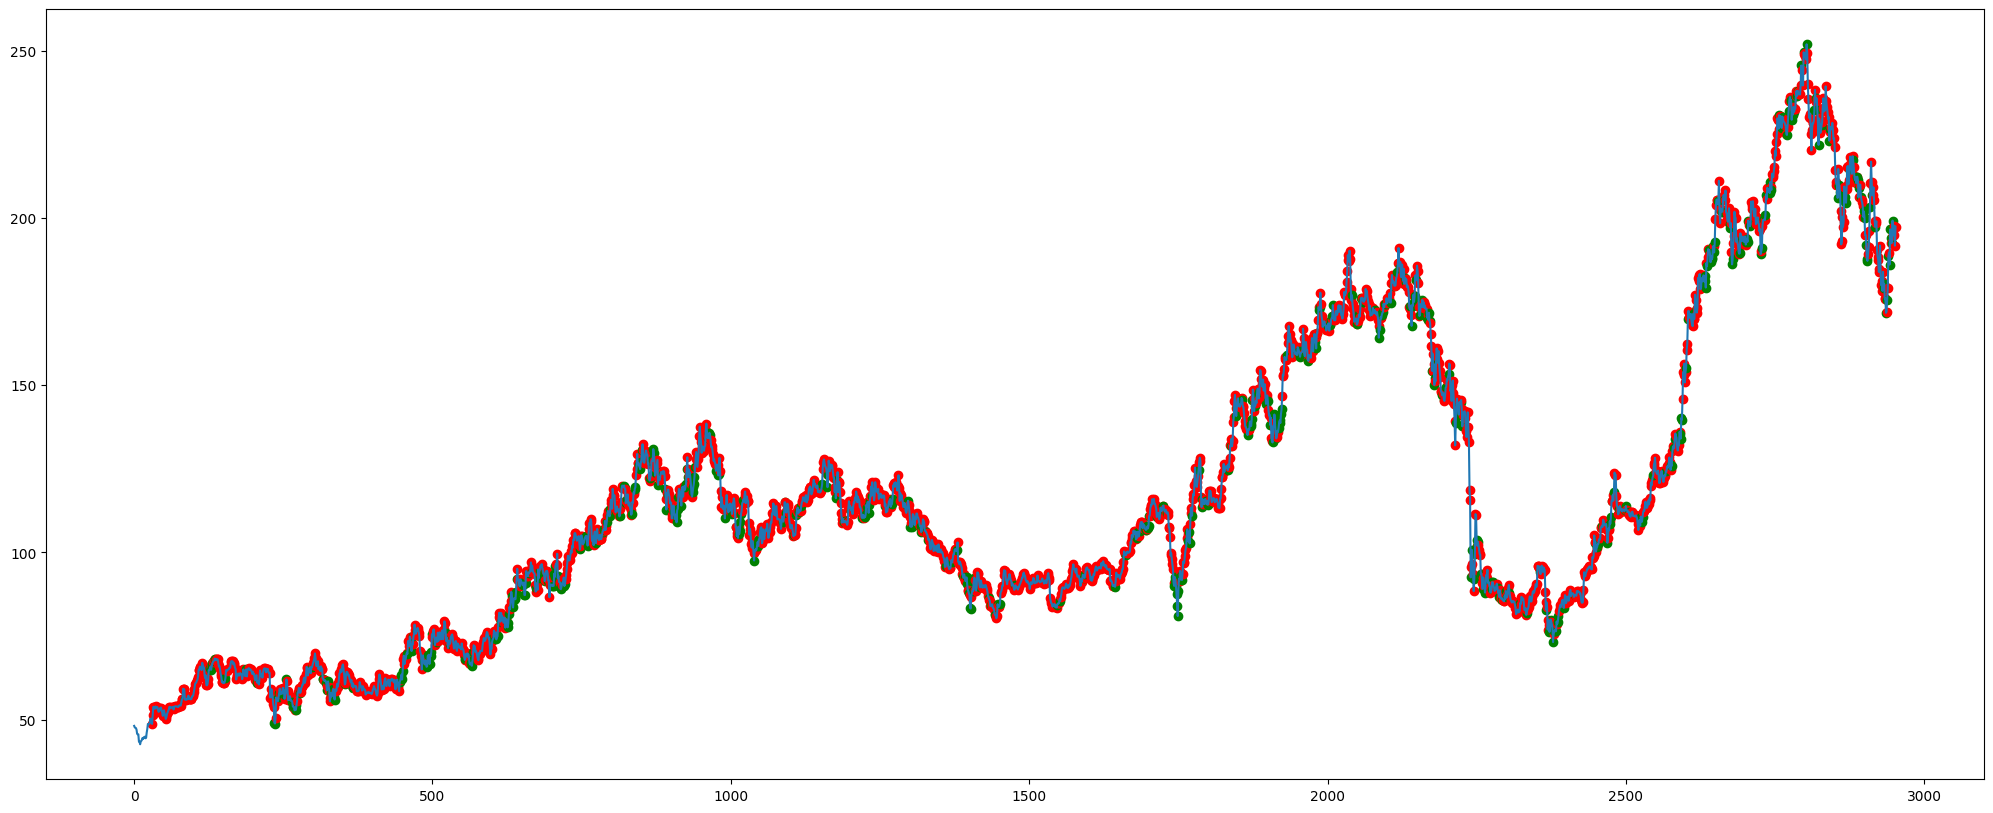

In [70]:
plt.figure(figsize = (25, 10))
dataf = environment.data[::REWARD_TIME]
plt.plot(dataf)
for e, a in enumerate(actions):
    print(f"{e} {a}", end='\r')
    e += WINDOW_SHAPE//REWARD_TIME
    if a == 1:
        plt.scatter(e, dataf[e], color = 'green')
    elif a == -1:
        plt.scatter(e, dataf[e], color = 'red')

plt.show()

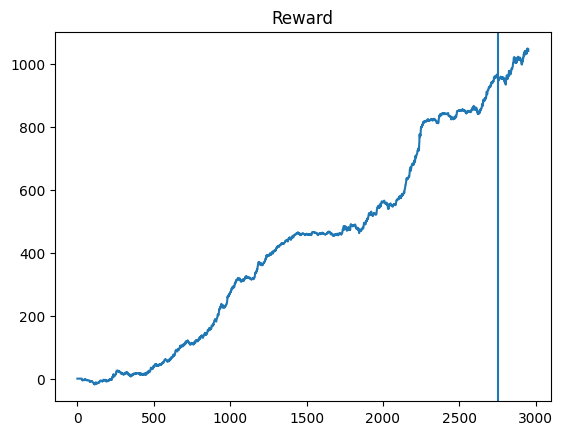

In [71]:
# We make a schedule of income. Let's make a frame of the Price format/The signal
backtest = pd.DataFrame({
    'price': dataf.flatten(),
    'signal': [0] * (WINDOW_SHAPE//REWARD_TIME) + actions
})
# We get price derivatives and make a shift
backtest['price_diff'] = backtest['price'].diff().shift(-1)
# We summarize the income and display a graph
(backtest['price_diff'] * backtest['signal']).cumsum().plot()
plt.title('Reward')

plt.axvline(x=(dataf.shape[0]-SIZE_test)//REWARD_TIME)
plt.show()

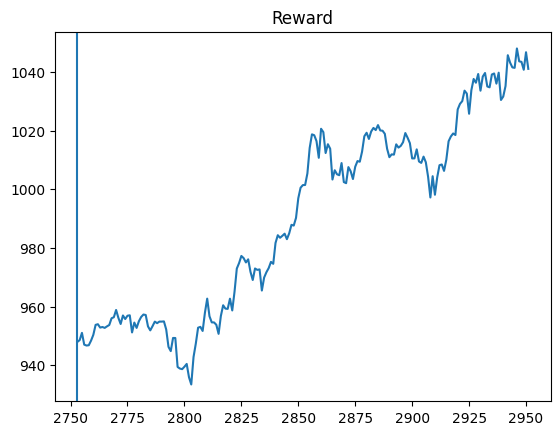

In [72]:
# We make a schedule of income. Let's make a frame of the Price format/The signal
backtest = pd.DataFrame({
    'price': dataf.flatten(),
    'signal': [0] * (WINDOW_SHAPE//REWARD_TIME) + actions
})
# We get price derivatives and make a shift
backtest['price_diff'] = backtest['price'].diff().shift(-1)
# We summarize the income and display a graph
(backtest['price_diff'] * backtest['signal']).cumsum()[-200:].plot()
plt.title('Reward')

plt.axvline(x=(dataf.shape[0]-SIZE_test)//REWARD_TIME)
plt.show()

In [87]:
if actions[-1] == 1:
  print('buy')
else:
  print('sell')

sell
